In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

In [2]:
dataset_folder = "dataset/cleaned"
sensor_name = "Sensor 2"
save_folder = f"saved_model/{sensor_name}"

In [3]:
train_data = pd.read_csv(
    f"{dataset_folder}/train/{sensor_name}_train.csv"
)
val_data = pd.read_csv(
    f"{dataset_folder}/val/{sensor_name}_val.csv"
)
test_data = pd.read_csv(
    f"{dataset_folder}/test/{sensor_name}_test.csv"
)

train_data["created_at"] = pd.to_datetime(train_data["created_at"], format="ISO8601")
val_data["created_at"] = pd.to_datetime(val_data["created_at"], format="ISO8601")
test_data["created_at"] = pd.to_datetime(test_data["created_at"], format="ISO8601")

train_data.set_index("created_at", inplace=True)
val_data.set_index("created_at", inplace=True)
test_data.set_index("created_at", inplace=True)

In [4]:
train_data = train_data[['power']]
val_data = val_data[['power']]
test_data = test_data[['power']]

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [6]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [7]:
X_train, y_train = create_sequences(train_data_scaled, time_steps=24)
X_val, y_val = create_sequences(val_data_scaled, time_steps=24)
X_test, y_test = create_sequences(test_data_scaled, time_steps=24)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

d:\Daffa Titip\power-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=24, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 256s 12ms/step - loss: 0.0141 - val_loss: 6.1647e-04 - learning_rate: 0.0010
Epoch 2/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 249s 12ms/step - loss: 6.9357e-04 - val_loss: 2.2297e-04 - learning_rate: 0.0010
Epoch 3/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 251s 12ms/step - loss: 6.9837e-04 - val_loss: 6.5322e-05 - learning_rate: 0.0010
Epoch 4/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 250s 12ms/step - loss: 7.0223e-04 - val_loss: 1.4151e-04 - learning_rate: 0.0010
Epoch 5/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 254s 12ms/step - loss: 6.9596e-04 - val_loss: 6.3344e-05 - learning_rate: 0.0010
Epoch 6/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 252s 12ms/step - loss: 6.7942e-04 - val_loss: 6.4317e-05 - learning_rate: 0.0010
Epoch 7/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 251s 12ms/step - loss: 6.7849e-04 - val_loss: 6.2549e-05 - learning_rate: 0.0010
Epoch 8/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 248s 12ms/step - loss: 6.8695e-04 - val_loss: 7.8120e-05 - learning_rate: 0.0010
Epoc

In [10]:
model.export(save_folder)

INFO:tensorflow:Assets written to: saved_model/Sensor 2\assets


INFO:tensorflow:Assets written to: saved_model/Sensor 2\assets


Saved artifact at 'saved_model/Sensor 2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2280888579280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2280888580240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2280888581776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473147920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473148496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473150416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473150032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473150800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473151760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473151184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2281473152720: TensorSpec(shape=(), 

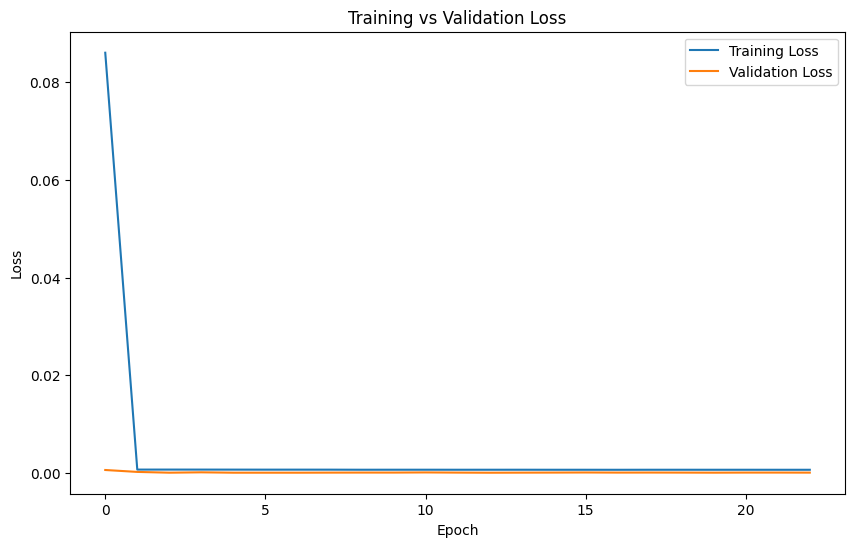

In [11]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(X_test)

10181/10181 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step


In [13]:
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

In [14]:
print("Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Performance Metrics:
Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.40
Root Mean Squared Error (RMSE): 0.63
R² Score: 0.999


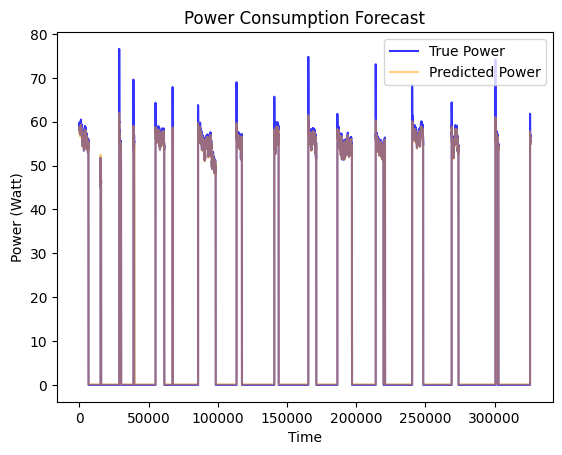

In [15]:
plt.plot(y_test_rescaled, label='True Power', color='blue', alpha=0.8)
plt.plot(y_pred_rescaled, label='Predicted Power', color='orange', alpha=0.5)
plt.legend()
plt.title("Power Consumption Forecast")
plt.xlabel("Time")
plt.ylabel("Power (Watt)")
plt.show()

MemoryError: Unable to allocate 123. GiB for an array with shape (16493096991,) and data type float64

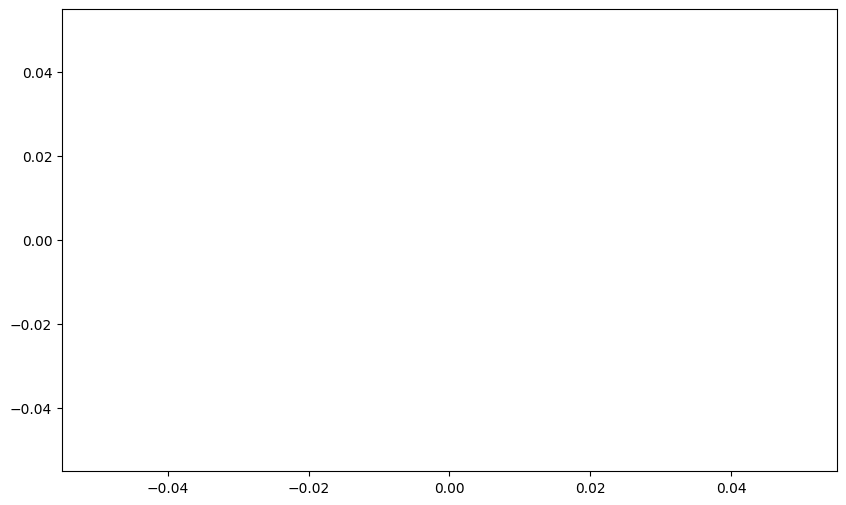

In [24]:
residuals = y_test_rescaled - y_pred_rescaled

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Error (Watt)')
plt.show()

In [19]:
result_df = pd.DataFrame({
    'time': test_data.index[24:].strftime('%Y-%m-%dT%H:%M:%S'),
    'predicted_power': y_pred_rescaled.flatten(),
    'actual_power': y_test_rescaled.flatten(),
})

In [20]:
result_df['time'] = pd.to_datetime(result_df['time'], format="ISO8601")
result_df['date'] = result_df['time'].dt.date
daily_counts = result_df.groupby(['date']).size().reset_index(name='count')
daily_counts["date"] = daily_counts["date"].astype(str)

dates = []
predicted_energy = []
actual_energy = []
different = []

for _, row in daily_counts.iterrows():
    date = row["date"]
    
    sensor_data = result_df[result_df["date"] == pd.to_datetime(date).date()]
    sensor_data = sensor_data.sort_values(by="time")
    
    sensor_data["time_diff"] = sensor_data["time"].diff().dt.total_seconds()
    average_interval = sensor_data["time_diff"].mean()
    
    total_energy_predicted = 0
    total_energy_actual = 0
    for _, row in sensor_data.iterrows():
        predicted_power = row["predicted_power"]
        actual_power = row["actual_power"]
        interval = average_interval / 3600

        predicted_energy_value = (predicted_power * interval) / 1000
        total_energy_predicted += predicted_energy_value

        actual_energy_value = (actual_power * interval) / 1000
        total_energy_actual += actual_energy_value

    dates.append(date)
    predicted_energy.append(total_energy_predicted)
    actual_energy.append(total_energy_actual)
    different.append(total_energy_actual - total_energy_predicted)

    print(f"Different energy consumption ({date}):", total_energy_actual - total_energy_predicted, "kWh")

Different energy consumption (2024-11-10): 0.0004024052710392967 kWh
Different energy consumption (2024-11-11): -0.0012840273619503795 kWh
Different energy consumption (2024-11-12): -0.0005343376922169463 kWh
Different energy consumption (2024-11-13): 0.0017367760333617532 kWh
Different energy consumption (2024-11-14): -0.0013007201315078376 kWh
Different energy consumption (2024-11-15): -0.001011013031099628 kWh
Different energy consumption (2024-11-16): 0.00053568412484023 kWh
Different energy consumption (2024-11-17): 0.000981889069184061 kWh
Different energy consumption (2024-11-18): -3.401049461054795e-05 kWh
Different energy consumption (2024-11-19): 0.0014579698015316778 kWh
Different energy consumption (2024-11-20): -0.0010837732714499004 kWh
Different energy consumption (2024-11-21): -0.0016328050860704851 kWh


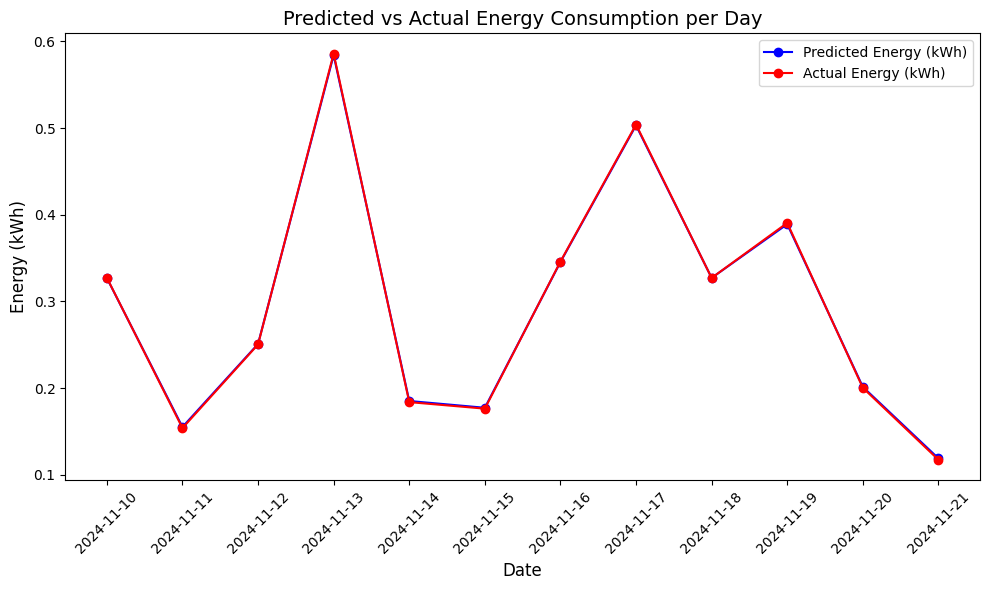

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_energy, label="Predicted Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.plot(dates, actual_energy, label="Actual Energy (kWh)", marker='o', linestyle='-', color='red')
plt.title("Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

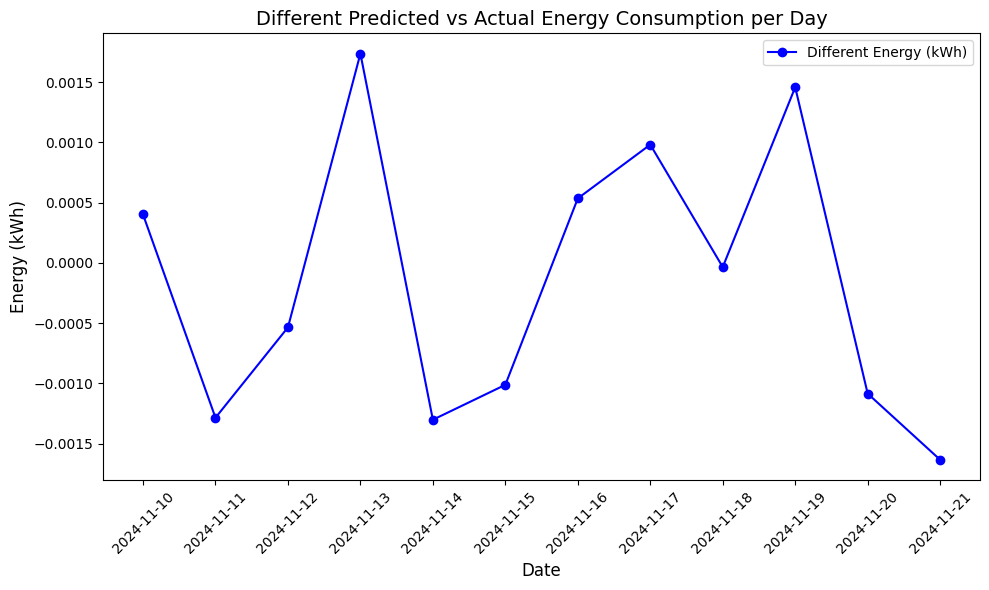

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(dates, different, label="Different Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.title("Different Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()